In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path=Path('data/btp/camdata/')
path.ls()

[PosixPath('data/btp/camdata/ind_test3.jpg'),
 PosixPath('data/btp/camdata/test'),
 PosixPath('data/btp/camdata/train_annot'),
 PosixPath('data/btp/camdata/val.txt'),
 PosixPath('data/btp/camdata/.git'),
 PosixPath('data/btp/camdata/train.txt'),
 PosixPath('data/btp/camdata/ind_test5.jpg'),
 PosixPath('data/btp/camdata/test-2.jpg'),
 PosixPath('data/btp/camdata/test_cam3.png'),
 PosixPath('data/btp/camdata/test_annot'),
 PosixPath('data/btp/camdata/ind_test.jpg'),
 PosixPath('data/btp/camdata/test_cam2.png'),
 PosixPath('data/btp/camdata/train'),
 PosixPath('data/btp/camdata/ind_test2.jpg'),
 PosixPath('data/btp/camdata/test-1.jpg'),
 PosixPath('data/btp/camdata/.ipynb_checkpoints'),
 PosixPath('data/btp/camdata/test_cam4.png'),
 PosixPath('data/btp/camdata/test_cam1.png'),
 PosixPath('data/btp/camdata/test.txt'),
 PosixPath('data/btp/camdata/ind_test4.jpg'),
 PosixPath('data/btp/camdata/images')]

In [4]:
train_imgs=path/'train'
train_annot=path/'train_annot'

In [5]:
fnames = get_image_files(train_imgs)
len(fnames)
# len(train_imgs.ls())

468

In [6]:
lbl_names = get_image_files(train_annot)
len(lbl_names)

468

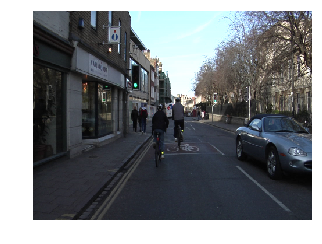

In [7]:
img_f = fnames[7]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: train_annot/f'{x.stem}{x.suffix}'
get_y_fn(img_f)

PosixPath('data/btp/camdata/train_annot/0016E5_08045.png')

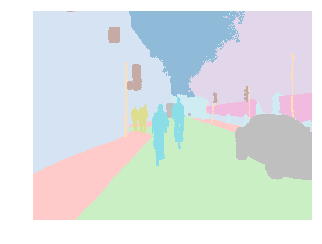

In [9]:
mask=open_mask('data/btp/camdata/train_annot/0016E5_08045.png')
mask.show(figsize=(5,5))

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[ 1,  1,  1,  ...,  5,  5,  5],
          [ 1,  1,  1,  ...,  5,  5,  5],
          [ 1,  1,  1,  ...,  5,  5,  5],
          ...,
          [ 4,  4,  4,  ...,  3,  3,  3],
          [ 4,  4,  4,  ...,  3,  3,  3],
          [ 4,  4,  4,  ...,  3,  3,  3]]]))

In [11]:
codes=['Sky','Building','Road_marking','Road','Pavement','Tree','SignSymbol','Fence'
       ,'Car','Pedestrian','Bicyclist','Unlabelled','Void']

TRAINING

In [12]:
src = (SegmentationItemList.from_folder(train_imgs)
       .random_split_by_pct(valid_pct=0.1)
       .label_from_func(get_y_fn, classes=codes))

In [13]:
data = (src.transform(get_transforms(), size=src_size, tfm_y=True)
        .databunch(bs=8)
        .normalize(imagenet_stats))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


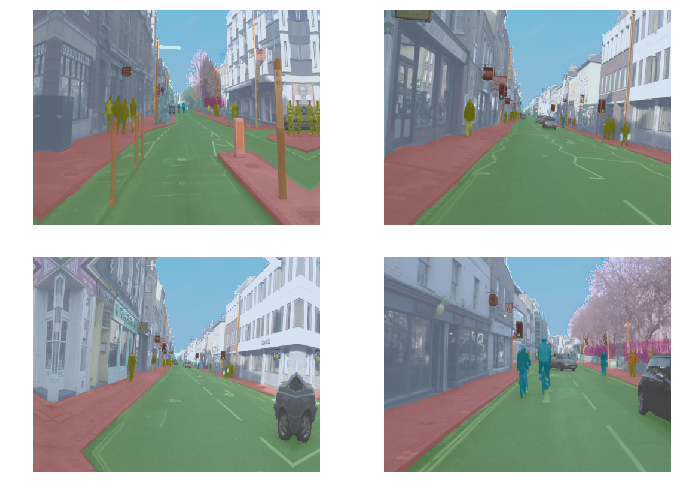

In [14]:
data.show_batch(2, figsize=(10,7))

In [15]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [16]:
metrics=acc_camvid

In [17]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


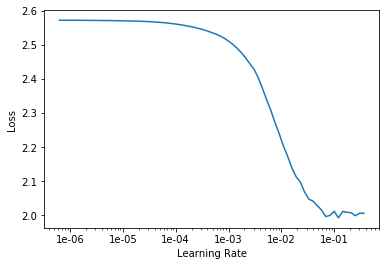

In [45]:
lr_find(learn)
learn.recorder.plot()

In [46]:
lr=6e-3

In [47]:
learn.fit_one_cycle(12, slice(lr))

Total time: 03:59
epoch  train_loss  valid_loss  acc_camvid
1      1.591568    1.408076    0.668108    (00:24)
2      0.857519    0.535574    0.845647    (00:19)
3      0.605766    0.451190    0.867599    (00:19)
4      0.500786    0.463382    0.864710    (00:19)
5      0.451036    0.456856    0.865681    (00:19)
6      0.403145    0.390708    0.873612    (00:19)
7      0.362754    0.307937    0.906452    (00:19)
8      0.326541    0.288561    0.910647    (00:19)
9      0.296601    0.287971    0.909019    (00:19)
10     0.276504    0.254638    0.919761    (00:19)
11     0.256007    0.250814    0.921457    (00:19)
12     0.249280    0.247439    0.922248    (00:19)



In [48]:
learn.save('stage-1-a');

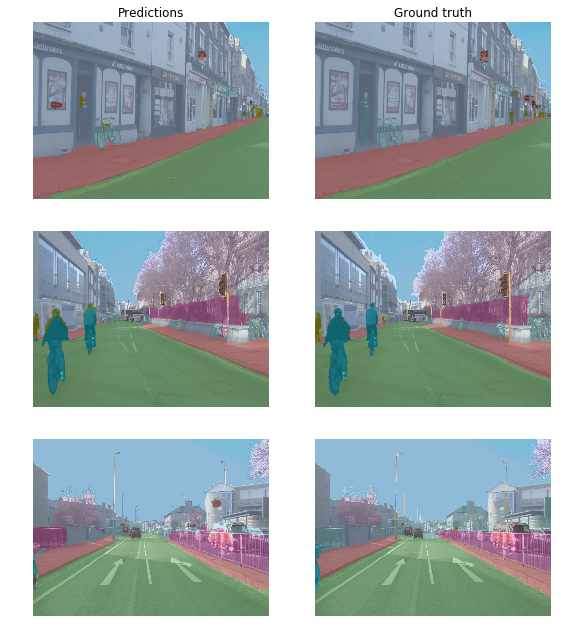

In [49]:
learn.show_results()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


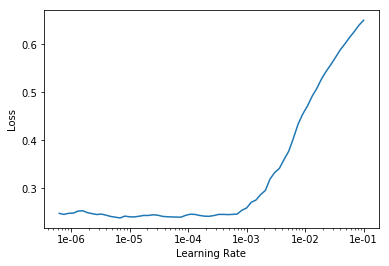

In [50]:
learn.unfreeze()
lr_find(learn)
learn.recorder.plot()

In [52]:
lrs = slice(1e-5,lr/20)

In [53]:
learn.fit_one_cycle(12, lrs)

Total time: 04:32
epoch  train_loss  valid_loss  acc_camvid
1      0.244507    0.247624    0.922273    (00:22)
2      0.241804    0.244385    0.922499    (00:22)
3      0.243165    0.247818    0.921846    (00:22)
4      0.244307    0.243030    0.923972    (00:22)
5      0.239176    0.247353    0.922286    (00:22)
6      0.235324    0.241809    0.923610    (00:22)
7      0.231548    0.242521    0.923434    (00:22)
8      0.229836    0.232399    0.926415    (00:22)
9      0.227523    0.232757    0.926066    (00:22)
10     0.224155    0.234011    0.925779    (00:22)
11     0.225968    0.232741    0.926097    (00:22)
12     0.219118    0.234490    0.925022    (00:23)



In [54]:
learn.save('stage-2-a')
learn.fit_one_cycle(30, lrs)

Total time: 11:25
epoch  train_loss  valid_loss  acc_camvid
1      0.212778    0.232870    0.925653    (00:22)
2      0.215086    0.234739    0.926284    (00:22)
3      0.216706    0.232511    0.926047    (00:22)
4      0.218788    0.233889    0.925858    (00:22)
5      0.216884    0.230311    0.926857    (00:22)
6      0.215095    0.231983    0.926444    (00:22)
7      0.214015    0.232913    0.925941    (00:22)
8      0.214502    0.238274    0.924465    (00:22)
9      0.213501    0.234539    0.926994    (00:22)
10     0.212693    0.228786    0.927143    (00:22)
11     0.208975    0.230826    0.927301    (00:22)
12     0.207623    0.227976    0.926229    (00:22)
13     0.206945    0.224023    0.928261    (00:22)
14     0.204935    0.220682    0.929697    (00:22)
15     0.202259    0.220714    0.930413    (00:22)
16     0.197864    0.227671    0.927700    (00:22)
17     0.197068    0.220087    0.930395    (00:22)
18     0.195032    0.220722    0.929963    (00:22)
19     0.192473    0.2

In [21]:
learn.save('stage-3-a');
# learn.load('stage-3-a');
# learn.path

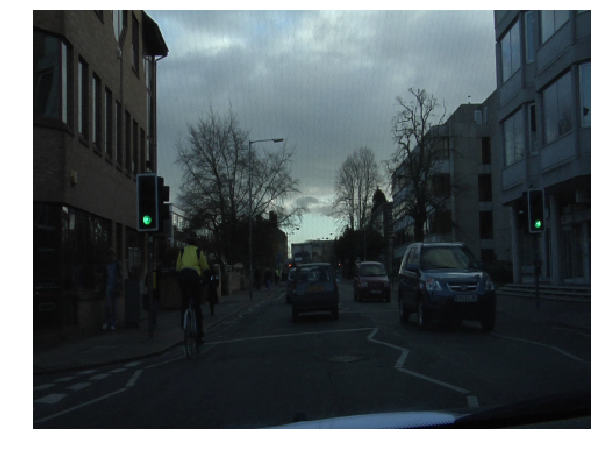

In [18]:
test_img = open_image(path/'test_cam1.png')
test_img.show(figsize=(10,10))

In [37]:
def get_pred_img(test_img,with_image=True):
    train_tfms, val_tfms = get_transforms()
    # img = apply_tfms(val_tfms, test_img, size=size)
    img_data= normalize(test_img.data, *list(map(tensor, imagenet_stats)))

    data2 = ImageDataBunch.single_from_classes(path/'train', classes=codes, tfms=get_transforms(), size=src_size, bs=1).normalize(imagenet_stats)
    learn2 = Learner.create_unet(data2, models.resnet34, pretrained=False)
    learn2 = learn2.load('stage-3-a')

    learn2.model.eval()
    probs_msk = learn2.model(img_data.cuda().unsqueeze(0))

    pred_msk = probs_msk.argmax(dim=1)
    pred_msk.shape

    pred_img_segment = ImageSegment(pred_msk)

#     fig, ax = plt.subplots(figsize=(10,10))
    fig, ax = plt.subplots(figsize=(10,10))
#     ax[0].imshow(test_img,aspect=float)
#     ax[1].imshow(pred_img_segment)
    if with_image:
        test_img.show(figsize=(10,10),ax=ax)
    pred_img_segment.show(figsize=(10,10),ax=ax, alpha=.7)
#     pred_img_segment.
    

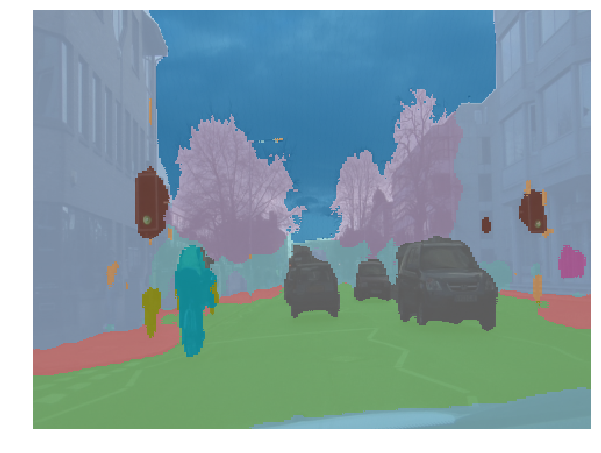

In [38]:
get_pred_img(test_img)

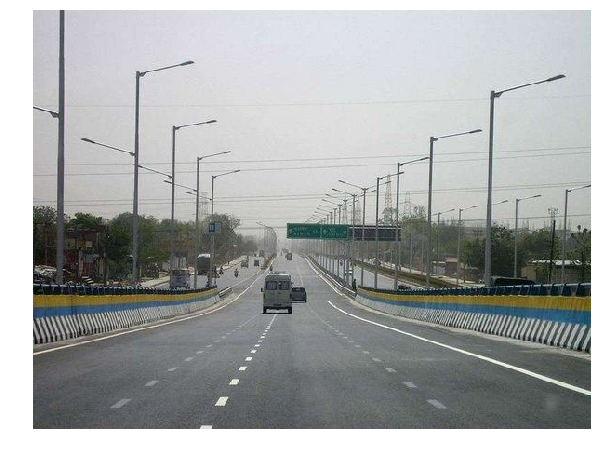

In [30]:
test_img1 = open_image(path/'ind_test4.jpg')
test_img1.show(figsize=(10,10))

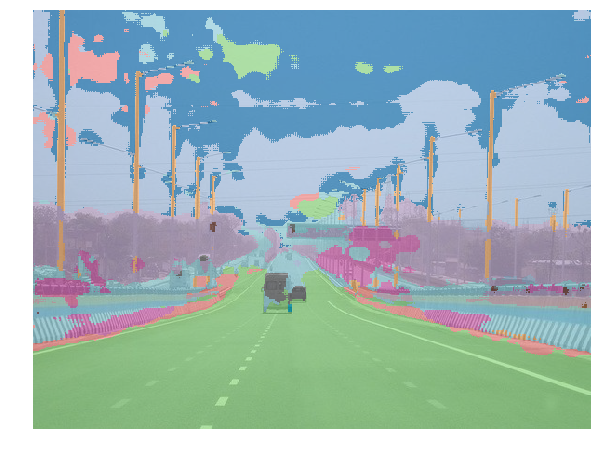

In [31]:
get_pred_img(test_img1)

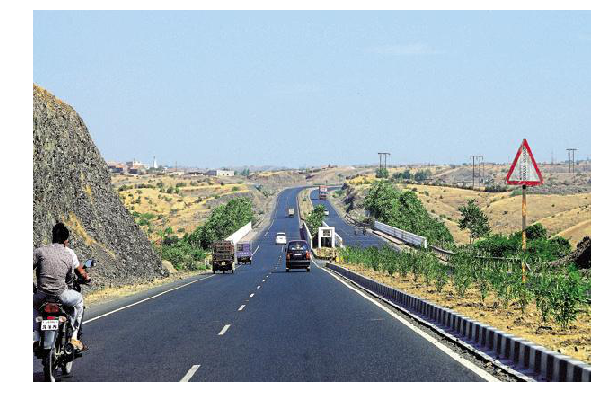

In [32]:
ind_img = open_image(path/'ind_test2.jpg')
ind_img.show(figsize=(10,10))

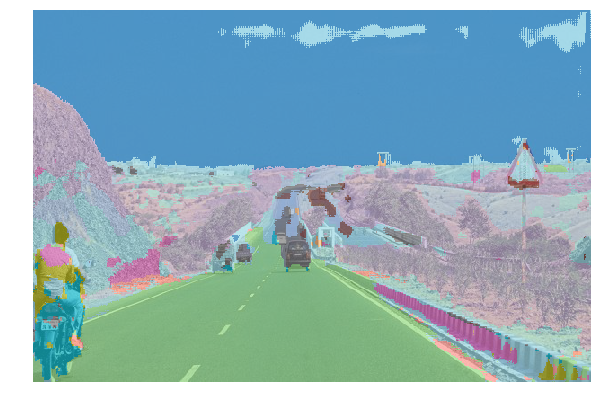

In [34]:
get_pred_img(ind_img)